# MLP
Mean RCI over 14 cell lines.

This notebook uses
lncRNA, longest transcript, no middle-exclusion train, no middle-exclusion test, -1 threshold, learning module, cross-validation.

In [1]:
SEED = 47
import tensorflow as tf
tf.random.set_seed(SEED) 
tf.keras.backend.set_floatx('float32')
import numpy as np
np.random.seed(SEED) 
from datetime import datetime
print(datetime.now())

2023-05-01 18:16:31.401493


In [2]:
import sys
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/Models/'  # must end in "/"
    sys.path.append('/content/drive/My Drive/Colab Notebooks')
except:
    IN_COLAB = False
    DATA_DIR="/"
    MODEL_DIR="/"
print(DATA_DIR)
SAVE_MODEL_FILENAME = None # 'MLP_NoNo'
SAVE_DESCRIM_FILENAME = None # 'GMM_NoNo'
LOAD_MODEL_FILENAME = None # 'MLP.0.0.model'
LOAD_DESCRIM_FILENAME = None # 'GMM.0.0.pickle'

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from learning import DataLoader, CrossValidator, Separator, ModelBuilder

K=5
ALPHABET=4**K + 1
EPOCHS=300 
EMBED_DIMEN = 4 # arbitrary hyperparameter
RCI_THRESHOLD_MECHANISM = 'ZERO'   # 'RCI_GMM' 'ZERO' 'THE_MEAN'
RCI_THRESHOLD_VALUE = -1  # use -1 for lncRNA, use 0 for mRNA
BREAK = False   # optionally break after first fold
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False
MIDDLE_LOW          = -2   # -2 for lncRNA, -1 for mRNA
MIDDLE_HIGH         = 0    #  0 for lncRNA, +1 for mRNA

REPEATS = 2
FOLDS = 5

Python 3.10.11
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.all_cell_lines.csv'
RCI_FILE_TEST  = None # 'test.lncRNA_RCI.all_cell_lines.csv'

SEQ_FILE_TRAIN = 'train.longest_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # 'test.longest_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()
EXCLUSIONS = [1]  # H1.hESC   
print('Exclusions',EXCLUSIONS)

Exclusions [1]


In [6]:
from tensorflow import keras
from keras import models
import pickle

def save_model(model, discriminator, filename1, filename2):
    filepath = MODEL_DIR + filename1
    model.save(filepath)
    print('Saved model 1 to',filepath)
    filepath = MODEL_DIR + filename2
    pickle.dump(discriminator, open(filepath, 'wb'))
    print('Saved model 2 to',filepath)

def load_model(filename1, filename2):
    filepath = MODEL_DIR + filename1
    model = keras.models.load_model(filepath)
    print('Loaded model 1 from',filepath)
    filepath = MODEL_DIR + filename2
    discriminator = pickle.load(open(filepath, 'rb'))        
    print('Loaded model 2 from',filepath)
    return model, discriminator
        

2023-05-01 18:16:35.709754
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 4372
Num RCI: 4372
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.longest_lncRNA_transcripts.csv
Loaded 4372 sequences.

Training # 1 1
2023-05-01 18:16:51.608114
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.1.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1810:1687 51.76%
Computed class weights: {0: 1.0364552459988146, 1: 0.9660220994475138}
Valid 1:0 433:442 49.49%
FIT


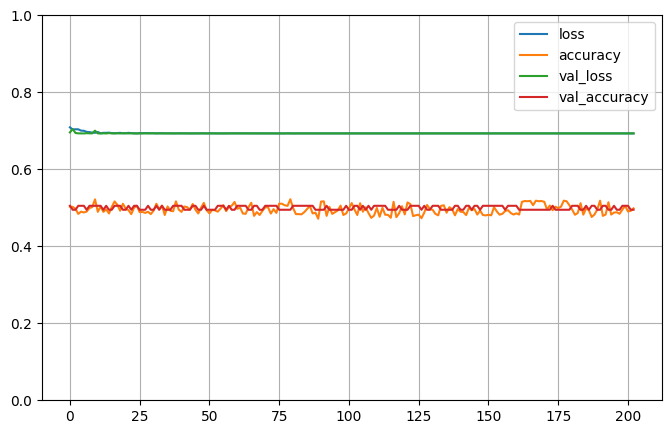


Testing # 1 1
2023-05-01 18:20:15.441637
PREDICT
Test 1:0 433:442 49.49%
Predict 1:0 0:875  0.00%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.49913457 mean 3.0729e-06 std
Range of scores: 0.4991265 to 0.4991476
Score threshold 0.5
Confusion matrix
 [[442   0]
 [433   0]]
Normalized matrix
 [[0.50514286 0.        ]
 [0.49485714 0.        ]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


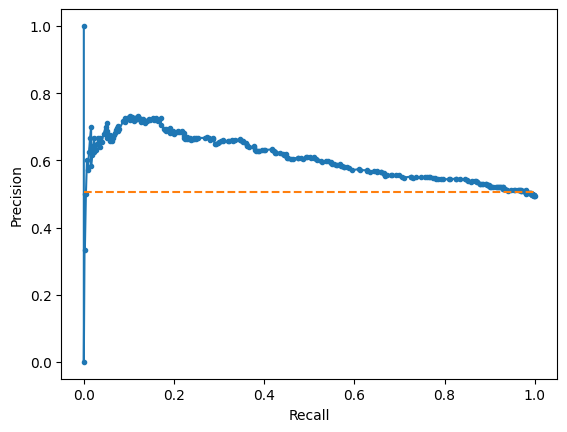

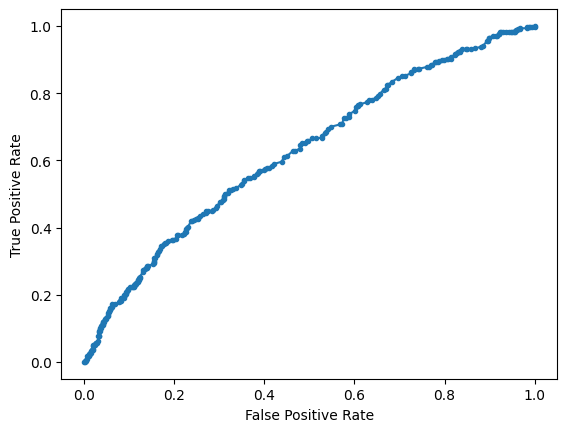

Accuracy: 50.51% Precision: 0.00% Recall: 0.00%
F1: 0.00% MCC: 0.0000
AUPRC: 60.54% AUROC: 62.59%
 accuracy [50.51428571428571]
 precision [0.0]
 recall [0.0]
 F1 [0.0]
 MCC [0.0]
 AUPRC [60.539415619494065]
 AUROC [62.5858213244438]

Training # 1 2
2023-05-01 18:20:16.250978
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.2.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1789:1708 51.16%
Computed class weights: {0: 1.023711943793911, 1: 0.9773616545556176}
Valid 1:0 454:421 51.89%
FIT


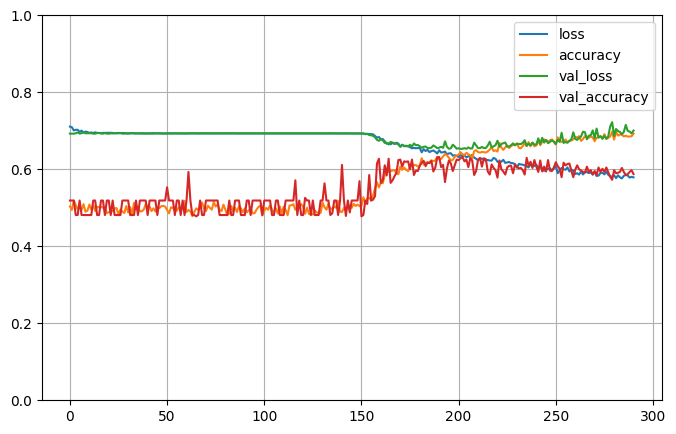


Testing # 1 2
2023-05-01 18:24:39.782734
PREDICT
Test 1:0 454:421 51.89%
Predict 1:0 568:307 64.91%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.5436003 mean 0.11919327 std
Range of scores: 0.11555375 to 0.84183955
Score threshold 0.5
Confusion matrix
 [[203 218]
 [104 350]]
Normalized matrix
 [[0.232      0.24914286]
 [0.11885714 0.4       ]]
Extreme scores correct, pos:neg 102 47
Extreme scores incorrect pos:neg 53 7


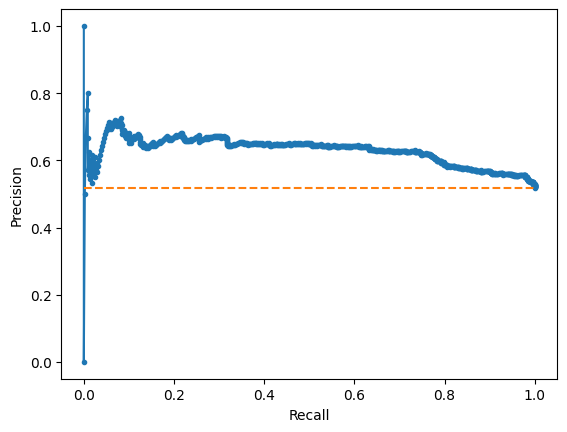

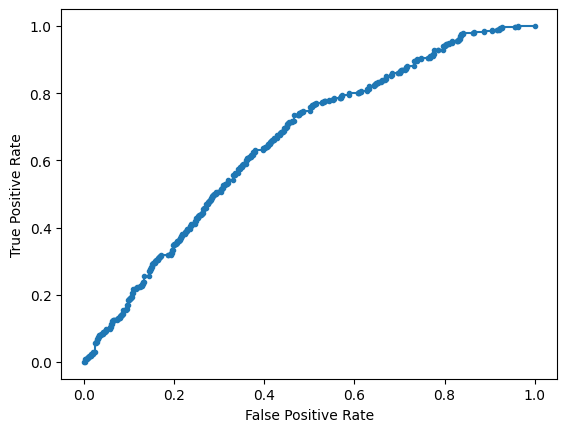

Accuracy: 63.20% Precision: 61.62% Recall: 77.09%
F1: 68.49% MCC: 0.2650
AUPRC: 62.97% AUROC: 65.47%
 accuracy [63.2]
 precision [61.61971830985915]
 recall [77.09251101321586]
 F1 [68.4931506849315]
 MCC [0.2649937190160691]
 AUPRC [62.97365615709596]
 AUROC [65.46977513158308]

Training # 1 3
2023-05-01 18:24:40.479186
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.3.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1810:1688 51.74%
Computed class weights: {0: 1.036137440758294, 1: 0.9662983425414364}
Valid 1:0 433:441 49.54%
FIT


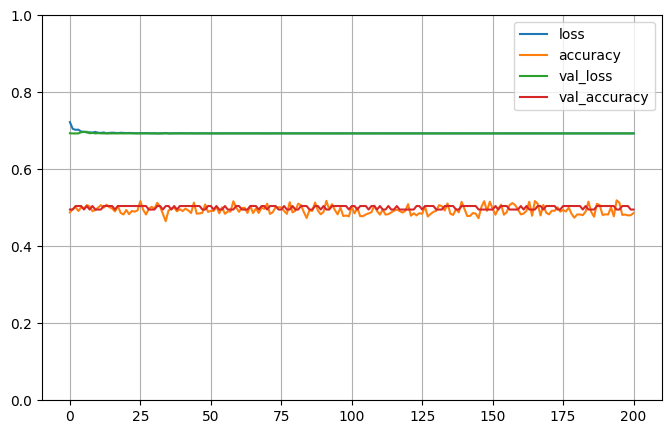


Testing # 1 3
2023-05-01 18:27:13.243024
PREDICT
Test 1:0 433:441 49.54%
Predict 1:0 0:874  0.00%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.49942768 mean 1.7495993e-06 std
Range of scores: 0.49941656 to 0.49943608
Score threshold 0.5
Confusion matrix
 [[441   0]
 [433   0]]
Normalized matrix
 [[0.50457666 0.        ]
 [0.49542334 0.        ]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


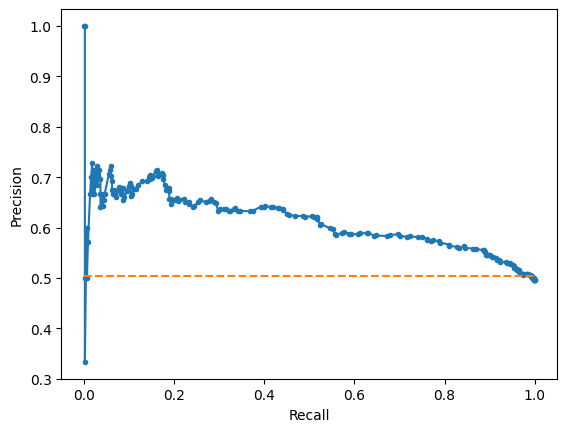

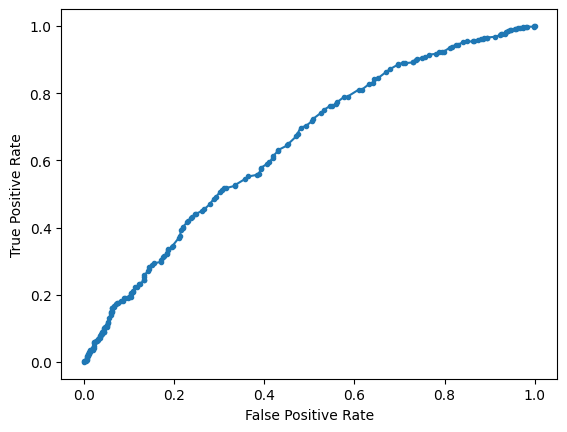

Accuracy: 50.46% Precision: 0.00% Recall: 0.00%
F1: 0.00% MCC: 0.0000
AUPRC: 61.21% AUROC: 64.53%
 accuracy [50.45766590389016]
 precision [0.0]
 recall [0.0]
 F1 [0.0]
 MCC [0.0]
 AUPRC [61.211118871354245]
 AUROC [64.53472844103]

Training # 1 4
2023-05-01 18:27:14.015653
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.4.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1778:1720 50.83%
Computed class weights: {0: 1.0168604651162791, 1: 0.9836895388076491}
Valid 1:0 465:409 53.20%
FIT


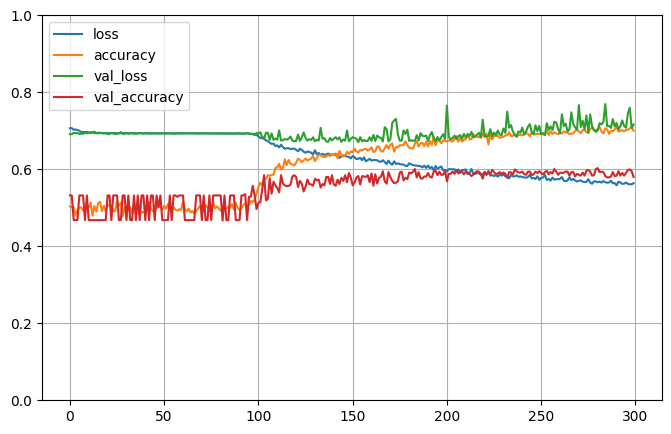


Testing # 1 4
2023-05-01 18:30:57.060696
PREDICT
Test 1:0 465:409 53.20%
Predict 1:0 484:390 55.38%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.51629233 mean 0.23210861 std
Range of scores: 0.00084337365 to 0.899477
Score threshold 0.5
Confusion matrix
 [[216 193]
 [174 291]]
Normalized matrix
 [[0.24713959 0.2208238 ]
 [0.19908467 0.33295195]]
Extreme scores correct, pos:neg 196 131
Extreme scores incorrect pos:neg 99 74


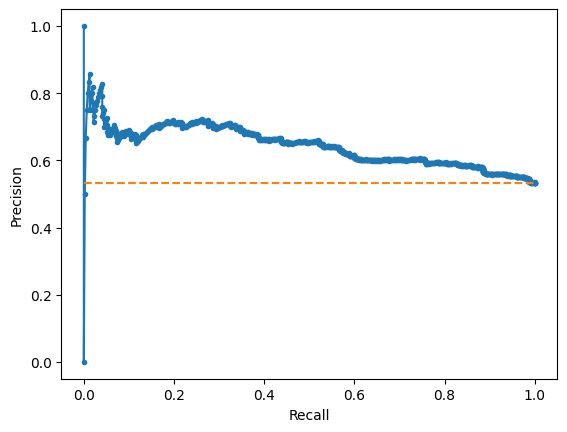

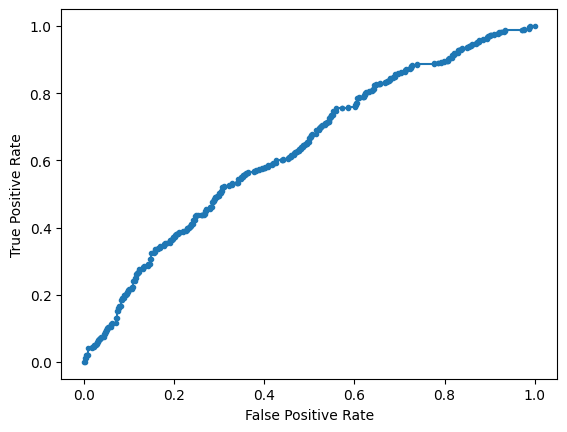

Accuracy: 58.01% Precision: 60.12% Recall: 62.58%
F1: 61.33% MCC: 0.1545
AUPRC: 64.28% AUROC: 63.42%
 accuracy [58.0091533180778]
 precision [60.12396694214877]
 recall [62.58064516129033]
 F1 [61.327713382507895]
 MCC [0.15450372472363422]
 AUPRC [64.27756240319692]
 AUROC [63.415621631569266]

Training # 1 5
2023-05-01 18:30:57.786184
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.5.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1785:1713 51.03%
Computed class weights: {0: 1.021015761821366, 1: 0.9798319327731092}
Valid 1:0 458:416 52.40%
FIT


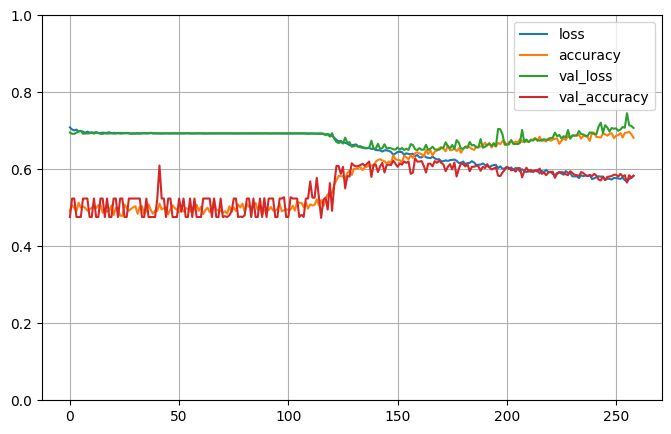


Testing # 1 5
2023-05-01 18:34:21.559713
PREDICT
Test 1:0 458:416 52.40%
Predict 1:0 401:473 45.88%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.4956037 mean 0.15166894 std
Range of scores: 0.07738238 to 0.8750495
Score threshold 0.5
Confusion matrix
 [[282 134]
 [191 267]]
Normalized matrix
 [[0.32265446 0.15331808]
 [0.21853547 0.30549199]]
Extreme scores correct, pos:neg 114 102
Extreme scores incorrect pos:neg 46 40


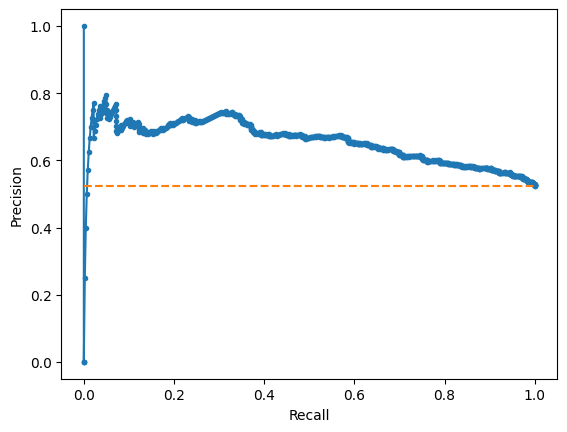

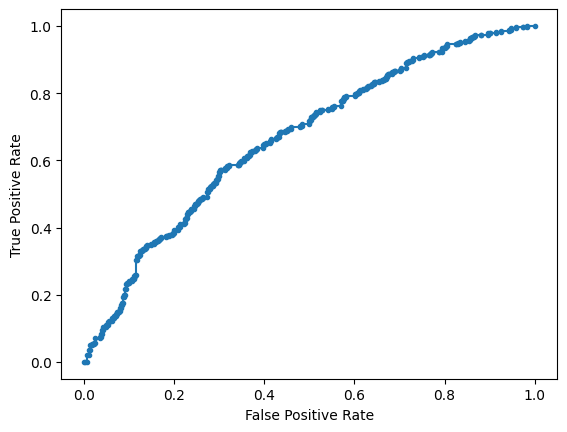

Accuracy: 62.81% Precision: 66.58% Recall: 58.30%
F1: 62.17% MCC: 0.2614
AUPRC: 65.49% AUROC: 66.49%
 accuracy [62.81464530892449]
 precision [66.58354114713218]
 recall [58.29694323144105]
 F1 [62.16530849825378]
 MCC [0.26144132009448007]
 AUPRC [65.48940463396345]
 AUROC [66.48839015787706]

Training # 2 1
2023-05-01 18:34:22.431986
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.1.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1807:1690 51.67%
Computed class weights: {0: 1.0346153846153847, 1: 0.9676258992805755}
Valid 1:0 436:439 49.83%
FIT


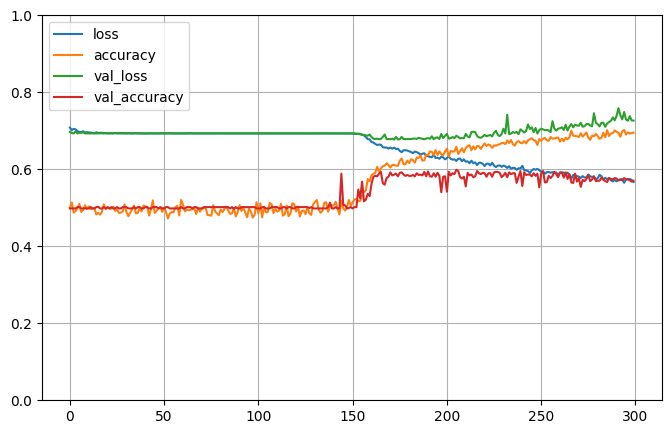


Testing # 2 1
2023-05-01 18:38:46.116754
PREDICT
Test 1:0 436:439 49.83%
Predict 1:0 584:291 66.74%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.55953616 mean 0.20238712 std
Range of scores: 0.0004277191 to 0.91119534
Score threshold 0.5
Confusion matrix
 [[177 262]
 [114 322]]
Normalized matrix
 [[0.20228571 0.29942857]
 [0.13028571 0.368     ]]
Extreme scores correct, pos:neg 203 96
Extreme scores incorrect pos:neg 138 52


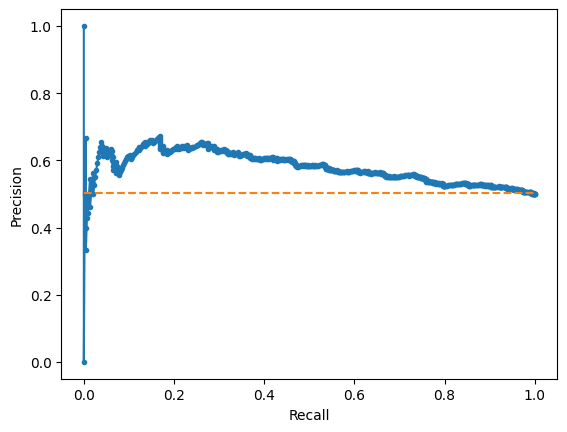

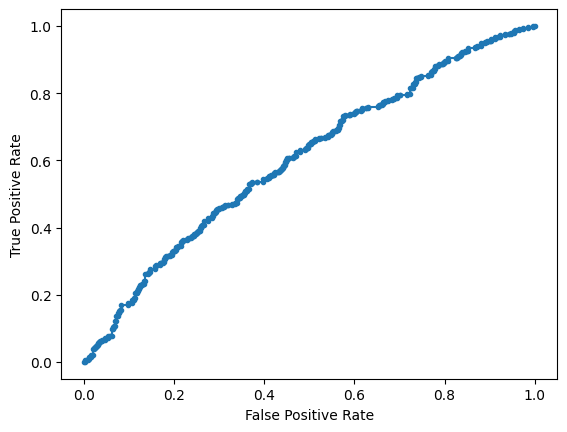

Accuracy: 57.03% Precision: 55.14% Recall: 73.85%
F1: 63.14% MCC: 0.1504
AUPRC: 57.83% AUROC: 60.34%
 accuracy [57.028571428571425]
 precision [55.13698630136986]
 recall [73.85321100917432]
 F1 [63.13725490196078]
 MCC [0.15040328940084585]
 AUPRC [57.83099742762807]
 AUROC [60.33520720570104]

Training # 2 2
2023-05-01 18:38:46.786628
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.2.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1794:1703 51.30%
Computed class weights: {0: 1.0267175572519085, 1: 0.9746376811594203}
Valid 1:0 449:426 51.31%
FIT


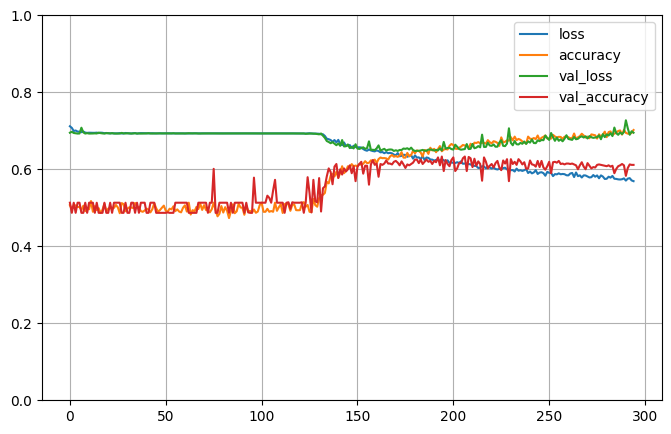


Testing # 2 2
2023-05-01 18:42:16.957495
PREDICT
Test 1:0 449:426 51.31%
Predict 1:0 456:419 52.11%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.50138676 mean 0.1598778 std
Range of scores: 0.0018206935 to 0.8298503
Score threshold 0.5
Confusion matrix
 [[262 164]
 [157 292]]
Normalized matrix
 [[0.29942857 0.18742857]
 [0.17942857 0.33371429]]
Extreme scores correct, pos:neg 111 112
Extreme scores incorrect pos:neg 58 37


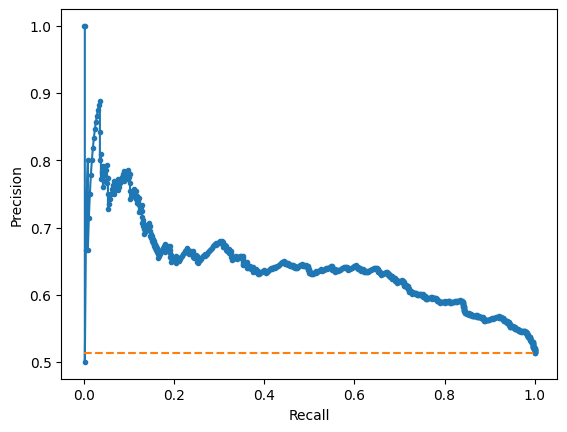

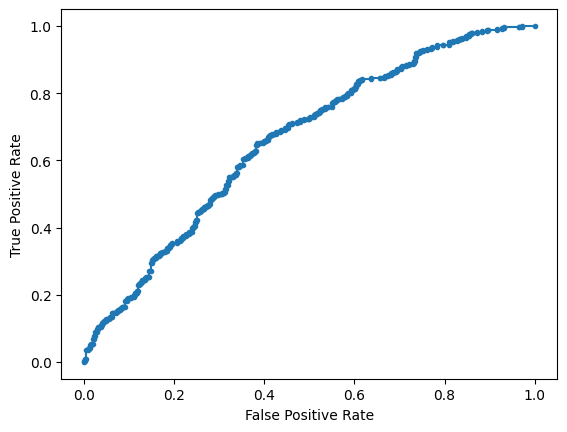

Accuracy: 63.31% Precision: 64.04% Recall: 65.03%
F1: 64.53% MCC: 0.2655
AUPRC: 64.33% AUROC: 65.89%
 accuracy [63.31428571428571]
 precision [64.03508771929825]
 recall [65.03340757238307]
 F1 [64.5303867403315]
 MCC [0.2655033381771437]
 AUPRC [64.33386102265742]
 AUROC [65.8944759873271]

Training # 2 3
2023-05-01 18:42:17.732869
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.3.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1771:1727 50.63%
Computed class weights: {0: 1.0127388535031847, 1: 0.9875776397515528}
Valid 1:0 472:402 54.00%
FIT


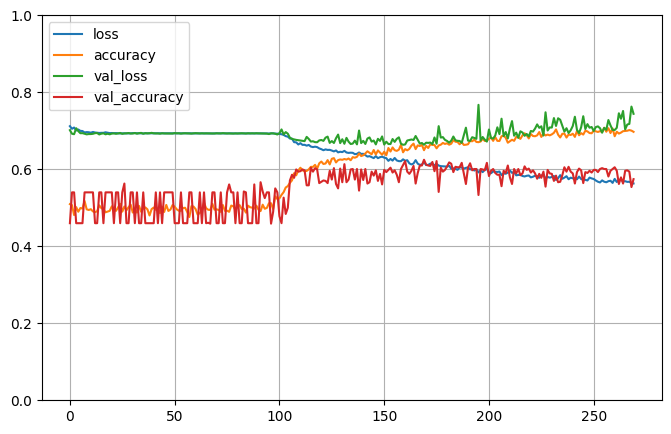


Testing # 2 3
2023-05-01 18:45:41.287320
PREDICT
Test 1:0 472:402 54.00%
Predict 1:0 618:256 70.71%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.569241 mean 0.15219255 std
Range of scores: 0.031045388 to 0.86867154
Score threshold 0.5
Confusion matrix
 [[165 237]
 [ 91 381]]
Normalized matrix
 [[0.18878719 0.27116705]
 [0.10411899 0.43592677]]
Extreme scores correct, pos:neg 177 61
Extreme scores incorrect pos:neg 101 18


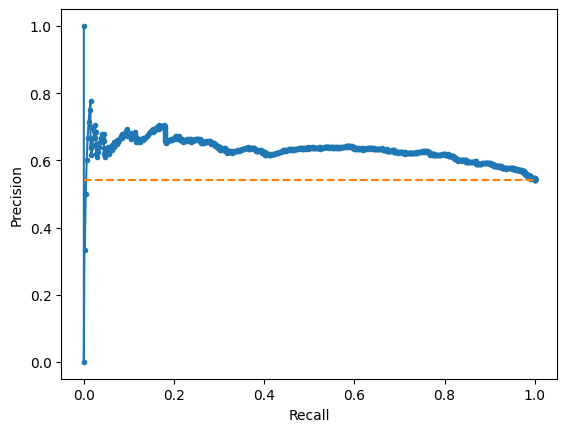

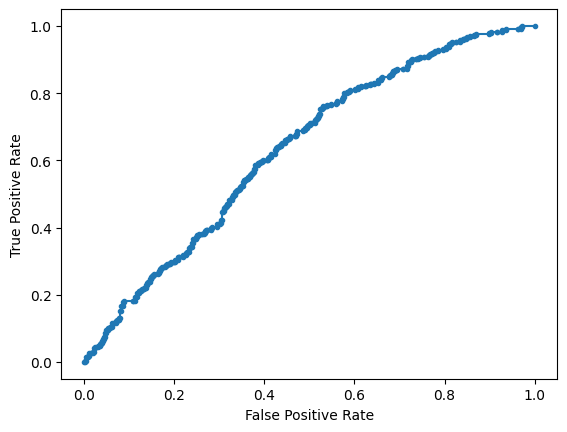

Accuracy: 62.47% Precision: 61.65% Recall: 80.72%
F1: 69.91% MCC: 0.2384
AUPRC: 62.99% AUROC: 63.28%
 accuracy [62.47139588100686]
 precision [61.6504854368932]
 recall [80.72033898305084]
 F1 [69.90825688073394]
 MCC [0.2383585714314876]
 AUPRC [62.98815006833848]
 AUROC [63.28157939117969]

Training # 2 4
2023-05-01 18:45:42.130620
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.4.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1816:1682 51.92%
Computed class weights: {0: 1.039833531510107, 1: 0.9631057268722467}
Valid 1:0 427:447 48.86%
FIT


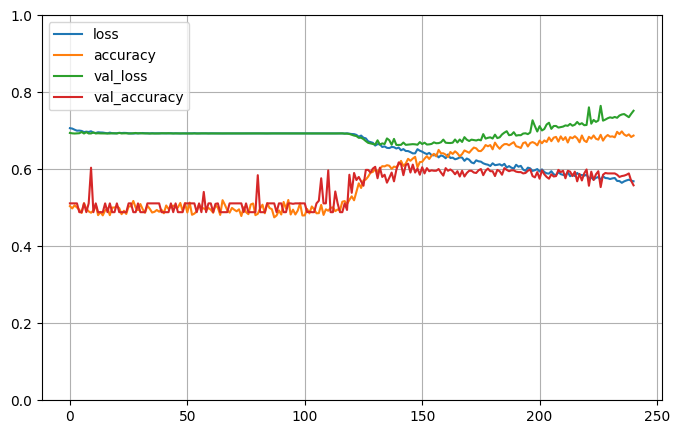


Testing # 2 4
2023-05-01 18:48:39.260060
PREDICT
Test 1:0 427:447 48.86%
Predict 1:0 351:523 40.16%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.4852929 mean 0.12472596 std
Range of scores: 0.20856087 to 0.88640946
Score threshold 0.5
Confusion matrix
 [[318 129]
 [205 222]]
Normalized matrix
 [[0.36384439 0.14759725]
 [0.23455378 0.25400458]]
Extreme scores correct, pos:neg 74 79
Extreme scores incorrect pos:neg 26 34


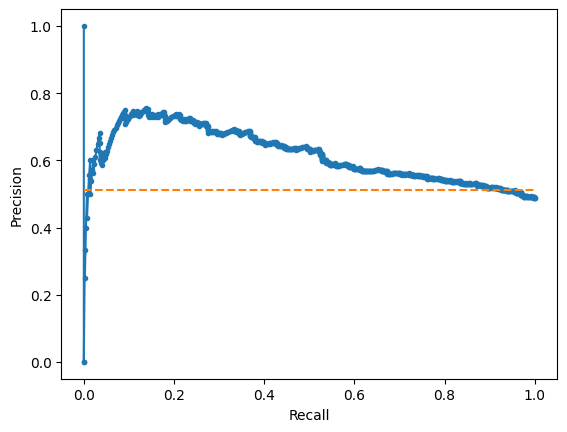

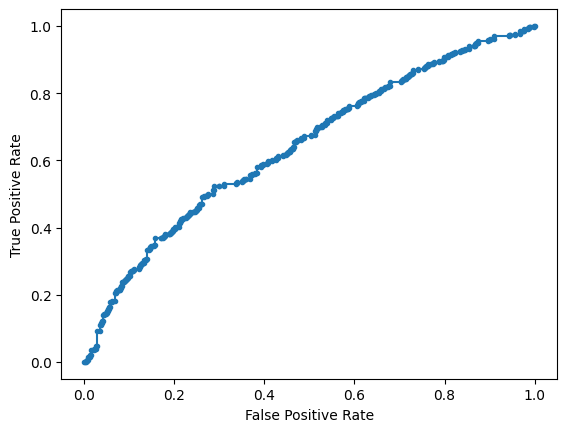

Accuracy: 61.78% Precision: 63.25% Recall: 51.99%
F1: 57.07% MCC: 0.2359
AUPRC: 61.44% AUROC: 64.09%
 accuracy [61.784897025171624]
 precision [63.24786324786324]
 recall [51.99063231850117]
 F1 [57.0694087403599]
 MCC [0.2358676840821684]
 AUPRC [61.44452128658846]
 AUROC [64.09264993267634]

Training # 2 5
2023-05-01 18:48:40.041407
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.5.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1784:1714 51.00%
Computed class weights: {0: 1.0204200700116686, 1: 0.9803811659192825}
Valid 1:0 459:415 52.52%
FIT


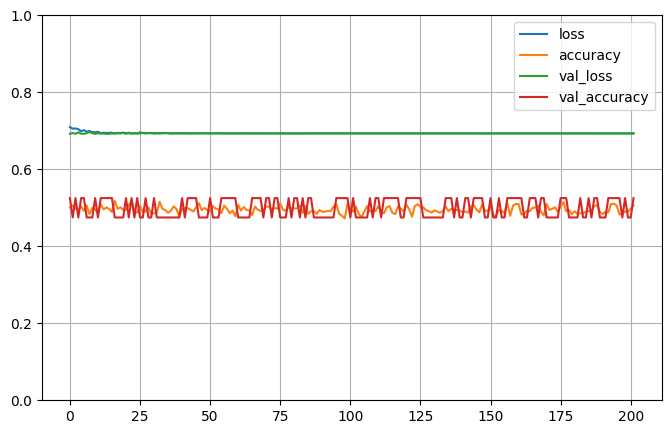


Testing # 2 5
2023-05-01 18:52:03.720776
PREDICT
Test 1:0 459:415 52.52%
Predict 1:0 874:0 100.00%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.5003691 mean 7.816608e-07 std
Range of scores: 0.5003672 to 0.50037265
Score threshold 0.5
Confusion matrix
 [[  0 415]
 [  0 459]]
Normalized matrix
 [[0.         0.47482838]
 [0.         0.52517162]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


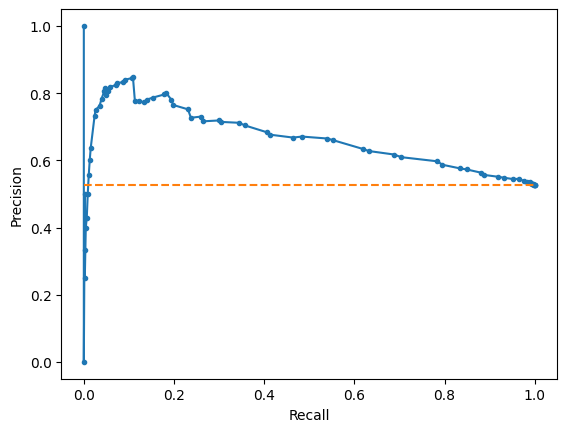

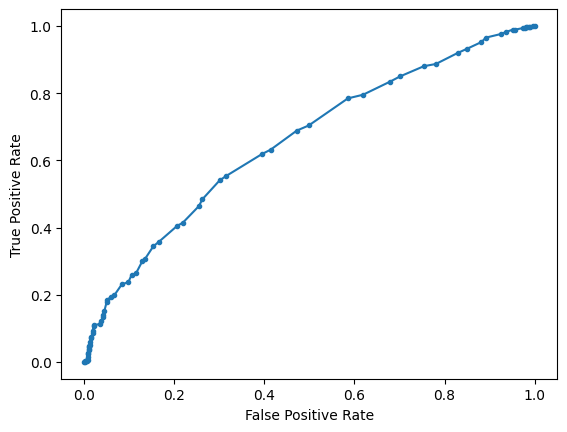

Accuracy: 52.52% Precision: 52.52% Recall: 100.00%
F1: 68.87% MCC: 0.0000
AUPRC: 66.47% AUROC: 65.47%
 accuracy [52.517162471395885]
 precision [52.517162471395885]
 recall [100.0]
 F1 [68.86721680420105]
 MCC [0.0]
 AUPRC [66.4689911822027]
 AUROC [65.46709714675696]
2023-05-01 18:52:04.491419


In [7]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader(K,ALPHABET)
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader(K,ALPHABET)
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        builder = ModelBuilder(ALPHABET)
        cvdo = CrossValidator(EPOCHS,RCI_THRESHOLD_VALUE)
        cvdo.set_model_builder(builder)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.set_middle(FILTER_TEST,FILTER_TAILS_TEST,FILTER_MIDDLE_TEST,\
                                 FILTER_TRAIN,FILTER_TAILS_TRAIN,FILTER_MIDDLE_TRAIN,\
                                 MIDDLE_LOW,MIDDLE_HIGH)
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
            if SAVE_MODEL_FILENAME is not None:
                filename1 = f"{SAVE_MODEL_FILENAME}.{show_r}.{show_f}.model"
                filename2 = f"{SAVE_DESCRIM_FILENAME}.{show_r}.{show_f}.pickle"
                model,discrim = cvdo.get_models()
                save_model(model,discrim,filename1,filename2)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            if LOAD_MODEL_FILENAME is not None:
                filename1 = LOAD_MODEL_FILENAME
                filename2 = LOAD_DESCRIM_FILENAME
                model, descrim = load_model(filename1, filename2)
                cvdo.set_models(model, descrim)
            else:
                cvdo.train_new_model(
                    train_allids,train_allseq,train_gene_to_rci,
                    None,None,None)

        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [8]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 58.21% std 5.34
 precision mean 48.49% std 25.89
 recall mean 56.96% std 32.86
 F1 mean 51.55% std 27.45
 MCC mean 0.1571 std 0.1160
 AUPRC mean 62.76% std 2.57
 AUROC mean 64.16% std 1.84
 accuracy [[50.51428571428571], [63.2], [50.45766590389016], [58.0091533180778], [62.81464530892449], [57.028571428571425], [63.31428571428571], [62.47139588100686], [61.784897025171624], [52.517162471395885]]
 precision [[0.0], [61.61971830985915], [0.0], [60.12396694214877], [66.58354114713218], [55.13698630136986], [64.03508771929825], [61.6504854368932], [63.24786324786324], [52.517162471395885]]
 recall [[0.0], [77.09251101321586], [0.0], [62.58064516129033], [58.29694323144105], [73.85321100917432], [65.03340757238307], [80.72033898305084], [51.99063231850117], [100.0]]
 F1 [[0.0], [68.4931506849315], [0.0], [61.327713382507895], [62.16530849825378], [63.13725490196078], [64.5303867403315], [69.90825688073394], [57.0694087403599], [68.86721680420105]]
 MCC [[0.0], [0.264993719016